In [1]:
from CoRe_Dataloader_From_File_With_Random_From_Tensors import get_new_ttv_dataloaders, get_new_test_train_validation_datasets
from CoRe_Dataloader_ECSG import dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import math
import torchinfo
import time
import numpy as np
import wandb
import datetime
from collections import OrderedDict

In [2]:
import torchmetrics as metrics
import pandas as pd
acc = metrics.Accuracy(task="multiclass", num_classes=19)
combined = metrics.MetricCollection([
    acc,
    metrics.AUROC(task="multiclass", num_classes=19),
    metrics.Precision(task="multiclass", num_classes=19),
    metrics.Recall(task="multiclass", num_classes=19),
    metrics.F1Score(task="multiclass", num_classes=19),
    metrics.FBetaScore(task="multiclass", num_classes=19)
])


def get_df_from_rdict(rdict):
    return pd.DataFrame(pd.Series(rdict).map(lambda x: x.item())).T


In [3]:
def calc_metrics(model:torch.nn.Module,dl:DataLoader):
    model.eval()
    raw_output = []
    parameters = []
    with torch.no_grad():
        for batch,(sg,params) in enumerate(dl):
            sg = sg.to("cuda:0").to(torch.float)
            sgsh = sg.shape
            sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

            params = params[:,0].to("cuda:0").to(torch.long)
            
            raw_output.append(model(sg).detach().cpu())
            parameters.append(params.cpu())
            # print(batch)
    model.train()
    output = torch.vstack(raw_output)
    parameters = torch.hstack(parameters)
    return combined(output,parameters)


In [4]:
# import vit
# import vit_pytorch
from vit_pytorch import vit_for_small_dataset as vit_sd
from vit_pytorch import vit as simple_vit
from vit_pytorch.deepvit import DeepViT

In [5]:
def init_model():
    # return simple_vit.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=int(1024/2),
    #                depth=2,
    #                heads=8,
    #                mlp_dim=int(2048/2),
    #                channels=1).to("cuda:0")
    # return vit_sd.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=1024,
    #                depth=4,
    #                heads=16,
    #                mlp_dim=int(2048/2),
    #                dropout = 0.1,
    #                emb_dropout = 0,
    #                channels=1).to("cuda:0")
    return DeepViT(image_size=400,
                    patch_size=20,
                    num_classes=19,
                    dim=1024,
                    depth=4,
                    heads=16,
                    mlp_dim=int(2048/2),
                    dropout=0.1,
                    emb_dropout=0.1,
                    channels=1).to("cuda:0")


In [6]:
model = init_model()
img = torch.randn(1,1, 400,400).to("cuda:0")
preds = model(img)  # (1, 1000)
print(preds)
torchinfo.summary(model, input_size=(1,1, 400, 40))

tensor([[-0.0838,  1.0363,  1.2129, -0.7509, -0.2309,  1.1294,  0.4624, -0.0459,
          0.1123, -0.0816,  0.4301, -0.6932, -0.9943,  0.3916, -0.1127,  0.1669,
         -0.7444, -0.7815,  0.2666]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


Layer (type:depth-idx)                                       Output Shape              Param #
DeepViT                                                      [1, 19]                   411,648
├─Sequential: 1-1                                            [1, 40, 1024]             --
│    └─Rearrange: 2-1                                        [1, 40, 400]              --
│    └─LayerNorm: 2-2                                        [1, 40, 400]              800
│    └─Linear: 2-3                                           [1, 40, 1024]             410,624
│    └─LayerNorm: 2-4                                        [1, 40, 1024]             2,048
├─Dropout: 1-2                                               [1, 41, 1024]             --
├─Transformer: 1-3                                           [1, 41, 1024]             --
│    └─ModuleList: 2-5                                       --                        --
│    │    └─ModuleList: 3-1                                  --                  

In [7]:
startlr = 3e-5
optimizer = optim.Adam(params=model.parameters(), lr=startlr)
optimizer1 = optim.NAdam(params=model.parameters(), lr=startlr)
step_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[1,2,3,4], gamma=0.5)
# at the end of 600 epochs, the learning rate is 0.000,002,62
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=0.8)
scheduler_pl = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.7, patience=35, verbose=True)
lossfn = nn.CrossEntropyLoss()


In [8]:
def to_seconds(s):
    return f"{s//3600}H:{(s%3600)//60}M:{s%60}S"
def ismult(n,div):
    return bool(1>>(n%div))

In [9]:
def train_eval_model(config, train_dl, test_dl, adam=True, nadam=False):
    ldl = len(train_dl)
    pre_acc,max_acc,max_auc = 0,0,0
    results = pd.DataFrame()
    best_model = OrderedDict()
    for epoch in range(1,config.epochs+1):
        
        print("preeval finished")
        etime = time.time()
        for batch,(sg,params) in enumerate(train_dl):
            stime = time.time()
            sgsh = sg.shape
            sg = sg.to("cuda:0").to(torch.float).view(sgsh[0],1,sgsh[1],sgsh[2])
            params = params[:,0].to("cuda:0").to(torch.long)
            optimizer.zero_grad()
            outputs = model(sg)
            loss = lossfn(outputs,params)
            loss.backward()
            optimizer.step() if adam else None
            optimizer1.step() if nadam else None
            #
            torch.cuda.empty_cache()
            #
            wandb.log({"loss": loss.item(), "batch_accuracy": acc(outputs.to(
                "cpu"), params.to("cpu")), "lr": scheduler.get_last_lr()[0], "epoch": epoch})
            
            print(
                f"{epoch:5}/{config.epochs:5} // {batch:5}/{ldl:5} | Loss: {loss.item():2.4},batch_accuracy:{acc(outputs.to('cpu'),params.to('cpu')):3.4}, lr:{scheduler.get_last_lr()[0]:1.5}, Time per Batch: {time.time()-stime:.3} seconds, Accumulated Time {to_seconds(round(time.time()-etime,3))}    ", end="\r", flush=True)
            
            if (batch-1) % 5000 == 0:
                epoch_results = calc_metrics(model, test_dl)
                results = pd.concat([results, get_df_from_rdict(epoch_results)])
                max_acc = max(results["MulticlassAccuracy"])
                max_auc = max(results["MulticlassAUROC"])
                #
                if pre_acc < max_acc:
                    best_model = model.state_dict()
                    try:
                        torch.save(
                            best_model, f"./saved_models/ViT/WithNoise/best_model_state_dict_ViT_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__acc_{max_acc}__auc_{max_auc}.pt")
                        print("\nSAVING MODEL")
                    except:
                        wandb.alert(level="warning", title="OUT OF MEMORY")

                wandb.log({"epoch": epoch, "lr": scheduler.get_last_lr()[0]} | epoch_results | {
                        "MaximumMulticlassAccuracy": max_acc, "MaximumMulticlassAUROC": max_auc} | {"EpochTime": time.time()-etime})
        #
        scheduler.step()
        step_scheduler.step()
        scheduler_pl.step(max_acc)
        #
        epoch_results = calc_metrics(model, test_dl)
        results = pd.concat([results, get_df_from_rdict(epoch_results)])
        max_acc = max(results["MulticlassAccuracy"])
        max_auc = max(results["MulticlassAUROC"])
        #
        if pre_acc < max_acc:
            best_model = model.state_dict()
            try:
                torch.save(best_model, f"./saved_models/ViT/WithNoise/best_model_state_dict_ViT_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__acc_{max_acc}__auc_{max_auc}.pt")
                print("\nSAVING MODEL")
            except:
                wandb.alert(level="warning",title="OUT OF MEMORY")

        wandb.log({"epoch":epoch,"lr":scheduler.get_last_lr()[0]} | epoch_results | {"MaximumMulticlassAccuracy": max_acc, "MaximumMulticlassAUROC":max_auc} | {"EpochTime": time.time()-etime})

    epoch_results = calc_metrics(model, test_dl)
    results = pd.concat([results, get_df_from_rdict(epoch_results)])
    return max_acc,max_auc

In [10]:
# uncomment for training
# results = []
# trials = 3
# for i in range(trials):
#     wandb.init(project="simple_vision_transformer_with_noise_classifier")
#     config = wandb.config
#     config.run_name = wandb.run._run_id
#     config = wandb.config
#     config.epochs = 3
#     config.inx = 400
#     config.iny = 400
#     config.lr = startlr     
#     config.trial = i+1
#     config.total_trials = trials
#     config.best_model = OrderedDict()
#     config.start_time = datetime.datetime.now().isoformat()
#     config.savename = f"best_model_state_dict_at_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__acc_max_acc__auc_auc.pt"
#     train_dl, valid_dl, test_dl = get_new_ttv_dataloaders()
#     train_eval_model(wandb.config,train_dl,valid_dl,nadam=True)
#     results.append(calc_metrics(model,test_dl)) #type: ignore
#     if i != (trials - 1):
#         model = init_model()

In [11]:
# eval_dl, _,_ = get_new_test_train_validation_datasets(0,0)
# eval_dl = torch.utils.data.DataLoader(eval_dl,batch_size=64)

In [12]:
# model.eval()
# raw_output = []
# parameters = []
# with torch.no_grad():
#     for batch,(sg,params) in enumerate(eval_dl):
#         sg = sg.to("cuda:0").to(torch.float)
#         sgsh = sg.shape
#         sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

#         params = params[:,0].to("cuda:0").to(torch.long)
        
#         raw_output.append(model(sg).detach().cpu())
#         parameters.append(params.cpu())
#         print(batch,"finished")
# model.train()
# output = torch.vstack(raw_output)
# parameters = torch.hstack(parameters)

In [13]:
model.load_state_dict(torch.load(
    r"C:\Users\aashr\Desktop\research\testing_grounds\saved_models\ViT\WithNoise\best_model_state_dict_ViT_forau0io70q_stime_2023-03-27T06-39-26.729202__acc_0.9905545115470886__auc_0.9999259114265442.pt"))


<All keys matched successfully>

In [14]:
_,_,evalds = get_new_test_train_validation_datasets(.1,.1)
evaldl = torch.utils.data.DataLoader(evalds,batch_size=64)

In [22]:
model.eval()
raw_output = []
parameters = []
with torch.no_grad():
    for batch,(sg,params) in enumerate(evaldl):
        sg = sg.to("cuda:0").to(torch.float)
        sgsh = sg.shape
        sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

        params = params[:,0].to("cuda:0").to(torch.long)

        raw_output.append(model(sg).detach().cpu())
        parameters.append(params.cpu())
        print(batch,"finished")
model.train()
output = torch.vstack(raw_output)
parameters = torch.hstack(parameters)


0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
10 finished
11 finished
12 finished
13 finished
14 finished
15 finished
16 finished
17 finished
18 finished
19 finished
20 finished
21 finished
22 finished
23 finished
24 finished
25 finished
26 finished
27 finished
28 finished
29 finished
30 finished
31 finished
32 finished
33 finished
34 finished
35 finished
36 finished
37 finished
38 finished
39 finished
40 finished
41 finished
42 finished
43 finished
44 finished
45 finished
46 finished
47 finished
48 finished
49 finished
50 finished
51 finished
52 finished
53 finished
54 finished
55 finished
56 finished
57 finished
58 finished
59 finished
60 finished
61 finished
62 finished
63 finished
64 finished
65 finished
66 finished
67 finished
68 finished
69 finished
70 finished
71 finished
72 finished
73 finished
74 finished
75 finished
76 finished
77 finished
78 finished
79 finished
80 finished
81 finished
82 finished
83 finished
84

In [25]:
roc = metrics.ROC(task="multiclass",num_classes=19)
fpr, tpr, thresholds = roc(output,parameters)

In [35]:
len(fpr)

19

In [31]:
import matplotlib.pyplot as plt

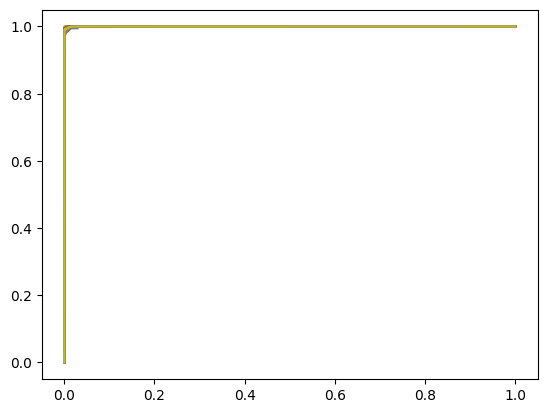

In [37]:
for i in range(len(fpr)):
    plt.plot(fpr[i],tpr[i])
plt.show() 

In [30]:
from sklearn.metrics import roc_curve

In [26]:
torch.save([fpr,tpr,thresholds],"roc.pt")

In [ ]:
output = torch.argmax(output,dim=1)

In [ ]:
output.shape

torch.Size([475365])

In [ ]:
parameters.shape

torch.Size([475365])

In [ ]:
comparisons = torch.eq(output,parameters).to(torch.float)

In [ ]:
torch.mean(comparisons)

tensor(0.9876)

In [ ]:
all_params = []
for batch,(sg,params) in enumerate(evaldl):
    all_params.append(params.cpu())
    print(batch,len(evaldl))

0 7428
1 7428
2 7428
3 7428
4 7428
5 7428
6 7428
7 7428
8 7428
9 7428
10 7428
11 7428
12 7428
13 7428
14 7428
15 7428
16 7428
17 7428
18 7428
19 7428
20 7428
21 7428
22 7428
23 7428
24 7428
25 7428
26 7428
27 7428
28 7428
29 7428
30 7428
31 7428
32 7428
33 7428
34 7428
35 7428
36 7428
37 7428
38 7428
39 7428
40 7428
41 7428
42 7428
43 7428
44 7428
45 7428
46 7428
47 7428
48 7428
49 7428
50 7428
51 7428
52 7428
53 7428
54 7428
55 7428
56 7428
57 7428
58 7428
59 7428
60 7428
61 7428
62 7428
63 7428
64 7428
65 7428
66 7428
67 7428
68 7428
69 7428
70 7428
71 7428
72 7428
73 7428
74 7428
75 7428
76 7428
77 7428
78 7428
79 7428
80 7428
81 7428
82 7428
83 7428
84 7428
85 7428
86 7428
87 7428
88 7428
89 7428
90 7428
91 7428
92 7428
93 7428
94 7428
95 7428
96 7428
97 7428
98 7428
99 7428
100 7428
101 7428
102 7428
103 7428
104 7428
105 7428
106 7428
107 7428
108 7428
109 7428
110 7428
111 7428
112 7428
113 7428
114 7428
115 7428
116 7428
117 7428
118 7428
119 7428
120 7428
121 7428
122 7428
123

In [ ]:
all_params = torch.vstack(all_params)

In [ ]:
all_params.shape

torch.Size([475365, 4])

In [ ]:
results = torch.cat((all_params,torch.unsqueeze(comparisons,dim=1)),dim=1)

In [ ]:
import pandas as pd

tensor(0.)

In [ ]:
df = pd.DataFrame(results.numpy())

In [ ]:
df = df.rename(columns = {0:"EOS",1:"M1",2:"M2",3:"SNR",4:"correct"})

In [ ]:
df["combined"] = df["M1"] + df["M2"]

In [ ]:
df = df.drop("M1",axis=1).drop("M2", axis=1)

In [ ]:
df.rename(columns={"combined":"Masses"})

,EOS,SNR,correct,Masses
0,14.0,2.105,1.0,2.700000
1,14.0,2.230,1.0,2.700000
2,14.0,2.355,1.0,2.700000
3,14.0,2.480,1.0,2.700000
4,14.0,2.605,1.0,2.700000
...,...,...,...,...
475360,16.0,2.780,1.0,2.750018
475361,16.0,2.905,1.0,2.750018
475362,10.0,3.005,1.0,2.750994
475363,15.0,2.155,1.0,2.700000


In [ ]:
by_eos_filter = {}
for i in df["EOS"].unique():
    # print(df[df["EOS"] == i].mean()["correct"])
    by_eos_filter[i] = [df[df["EOS"] == i].mean()["correct"]]

eosdf = pd.DataFrame(by_eos_filter)
eosdf = eosdf.reindex(sorted(eosdf.columns), axis=1)
remapper = {value: key for key, value in dataset.eosmap.items()}
eosdf  = eosdf.rename(columns = remapper)
eosdf

NameError: name 'df' is not defined

<AxesSubplot:>

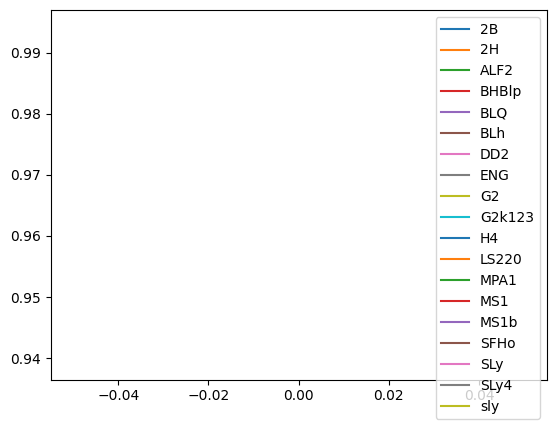

In [ ]:
by_snr_filter = {}
for i in df["SNR"].unique():
    # print(df[df["EOS"] == i].mean()["correct"])
    by_snr_filter[i] = [df[df["SNR"] == i].mean()["correct"]]

snrdf = pd.DataFrame(by_snr_filter)
snrdf = snrdf.reindex(sorted(snrdf.columns), axis=1)
# remapper = {value: key for key, value in dataset.eosmap.items()}
# eosdf.rename(columns=remapper)
# eosdf
snrdf.rename(columns = {0.000:-1}).T
snrdf

,0.000,0.005,0.030,0.055,0.080,0.105,0.130,0.155,0.180,0.205,...,4.755,4.780,4.805,4.830,4.855,4.880,4.905,4.930,4.955,4.980
0,0.99408,0.45666,0.67907,0.829598,0.884989,0.923467,0.953066,0.971247,0.974207,0.976321,...,0.994503,0.993235,0.994926,0.994926,0.99408,0.99408,0.99408,0.994503,0.995349,0.993658


In [ ]:
snrdf.T

,0
0.000,0.994080
0.005,0.456660
0.030,0.679070
0.055,0.829598
0.080,0.884989
...,...
4.880,0.994080
4.905,0.994080
4.930,0.994503
4.955,0.995349


<AxesSubplot:>

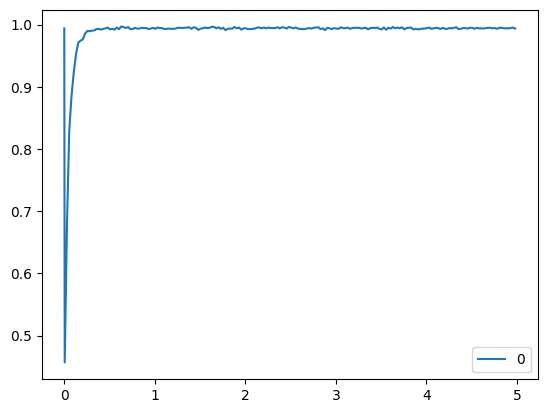

In [ ]:
snrdf.T.plot()

In [ ]:
# torch.save(model.state_dict,
#            f"./saved_models/ViT/WithNoise/best_model_state_dict_at_for{config.run_name}_stime_{config.start_time.replace(':', '-')}_BEST_MODEL.pt")


In [ ]:
df.to_csv("total_corrects_and_factors.pd.csv")
eosdf.to_csv("accuracy_by_eos.pd.csv")
snrdf.to_csv("accuracy_by_signal-to-noise-ratio.pd.csv")
